In [1]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import pyro
from pyro.distributions import Beta, Binomial, HalfCauchy, Normal, Pareto, Uniform
from pyro.distributions.util import scalar_like
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.mcmc.util import initialize_model, summary
from pyro.util import ignore_experimental_warning

In [3]:
import lbi.models
from lbi.nde import NeuralRatioEstimator
from lbi.sequential import Sequential

%load_ext autoreload
%autoreload 2

In [4]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [5]:
class MultivariateUniform():
    def __init__(self, low, high):
        self.dist = torch.distributions.Uniform(low, high)
        self.mean = self.dist.mean
        
    def log_prob(self, x):
        return self.dist.log_prob(x).sum(-1)
        
    def sample(self, it):
        return self.dist.sample(it)
    
        

In [6]:
# Simulation hyperparameters
num_dim = 3
observation = torch.zeros(1, num_dim)

In [7]:
def simulator(parameter_set):
    return 1.0 + parameter_set + torch.randn(parameter_set.shape) * 0.1

def simulation_wrapper(params, sims_per_model=1):
    """
    Returns summary statistics from conductance values in `params`.

    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    return simulator(params)

In [8]:
layers = [['Linear', 2*num_dim, 10], ['ReLU'], ['Linear', 10, 1]]
model = lbi.models.Classifier(layers=layers)
optimizer = torch.optim.AdamW(model.parameters())

In [9]:
priors = MultivariateUniform(low=-2*torch.ones(num_dim), high=2*torch.ones(num_dim))

nre = NeuralRatioEstimator(model)
snre = Sequential(priors=priors, 
                  obs_data=observation, 
                  param_dim=num_dim,
                  model=nre, 
                  optimizer=optimizer, 
                  simulator=simulation_wrapper, 
                  num_initial_samples=300,
                  num_samples_per_round=1000)

In [10]:
snre.run()

Training on 255 samples. Validating on 45 samples.
Round 1 complete. Time elapsed: 0m 0s. Total time elapsed: 0m 0s.
Training on 510 samples. Validating on 90 samples.


Warmup:   3%|▎         | 8/300 [00:00, 60.57it/s, step size=2.86e-02, acc. prob=0.595]

Round 2 complete. Time elapsed: 0m 0s. Total time elapsed: 0m 1s.


Sample: 100%|██████████| 300/300 [00:01, 188.00it/s, step size=1.44e-01, acc. prob=0.804]


Training on 1,360 samples. Validating on 240 samples.


Warmup:   5%|▍         | 14/300 [00:00, 139.46it/s, step size=3.32e-01, acc. prob=0.738]

Round 3 complete. Time elapsed: 0m 4s. Total time elapsed: 0m 4s.


Sample: 100%|██████████| 300/300 [00:01, 191.21it/s, step size=3.10e-01, acc. prob=0.808]


Training on 2,210 samples. Validating on 390 samples.


Warmup:   8%|▊         | 25/300 [00:00, 240.19it/s, step size=1.24e-01, acc. prob=0.729]

Round 4 complete. Time elapsed: 0m 5s. Total time elapsed: 0m 10s.


Sample: 100%|██████████| 300/300 [00:00, 357.52it/s, step size=6.28e-01, acc. prob=0.708]


Training on 3,060 samples. Validating on 540 samples.


Warmup:   8%|▊         | 24/300 [00:00, 219.17it/s, step size=9.42e-02, acc. prob=0.743]

Round 5 complete. Time elapsed: 0m 6s. Total time elapsed: 0m 15s.


Sample: 100%|██████████| 300/300 [00:00, 339.64it/s, step size=5.39e-01, acc. prob=0.746]


Training on 3,910 samples. Validating on 690 samples.


Warmup:   9%|▉         | 28/300 [00:00, 263.24it/s, step size=4.77e-02, acc. prob=0.776]

Round 6 complete. Time elapsed: 0m 8s. Total time elapsed: 0m 23s.


Sample: 100%|██████████| 300/300 [00:01, 294.12it/s, step size=4.64e-01, acc. prob=0.821]


Training on 4,760 samples. Validating on 840 samples.


Warmup:   9%|▉         | 28/300 [00:00, 251.09it/s, step size=2.72e-02, acc. prob=0.742]

Round 7 complete. Time elapsed: 0m 9s. Total time elapsed: 0m 32s.


Sample: 100%|██████████| 300/300 [00:01, 216.34it/s, step size=3.46e-01, acc. prob=0.873]


Training on 5,610 samples. Validating on 990 samples.


Warmup:  10%|▉         | 29/300 [00:00, 283.38it/s, step size=2.78e-02, acc. prob=0.744]

Round 8 complete. Time elapsed: 0m 11s. Total time elapsed: 0m 43s.


Sample: 100%|██████████| 300/300 [00:01, 238.11it/s, step size=3.39e-01, acc. prob=0.874]


Training on 6,460 samples. Validating on 1,140 samples.


Warmup:   9%|▉         | 27/300 [00:00, 263.70it/s, step size=3.81e-02, acc. prob=0.745]

Round 9 complete. Time elapsed: 0m 12s. Total time elapsed: 0m 55s.


Sample: 100%|██████████| 300/300 [00:01, 284.67it/s, step size=4.89e-01, acc. prob=0.816]


Training on 7,310 samples. Validating on 1,290 samples.
Round 10 complete. Time elapsed: 0m 14s. Total time elapsed: 1m 9s.


In [11]:
import corner

In [12]:
posterior_samples = snre.hmc(num_samples=30000, walker_steps=5000, burn_in=200)

Sample: 100%|██████████| 5200/5200 [00:16, 315.69it/s, step size=4.92e-01, acc. prob=0.813]


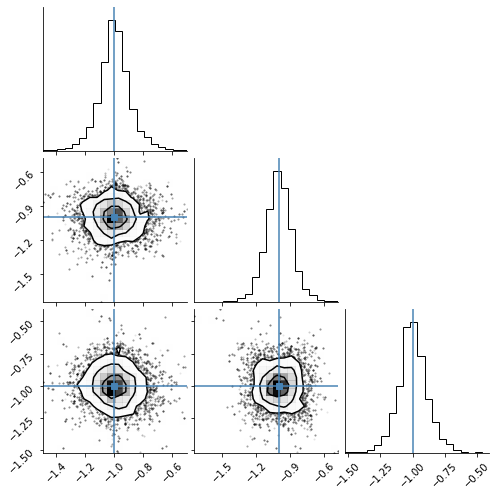

In [13]:
corner.corner(posterior_samples.numpy(), 
#               range=[(-2, 2) for i in range(num_dim)], 
                    truths=-torch.ones(num_dim).numpy());